![ Image](https://media.cnn.com/api/v1/images/stellar/prod/171215183408-california-fire-1213-restricted.jpg?q=w_2931,h_1649,x_0,y_0,c_fill/h_447)


# A Beginner's Python Analysis of the Impacts of the Thomas Fire
## *In Santa Barbara & Ventura Counties (Dec. 2017 - Jan. 2018)*

**Author:** Nicole Pepper

The Thomas Fire, which ignited on December 4, 2017, burned approximately 281,893 acres in Ventura and Santa Barbara counties, making it one of the largest and most devastating wildfires in California's history. The fire left behind extensive burn scars with widespread loss of vegetation and unstable soil, leaving the region vulnerable to erosion. In 2018, heavy rains caused massive flooding and debris flows, which resulted in catastrophic damage and tragic loss of life.

Here I share my beginner's `Python` exercise exploring some of the impacts of the Thomas Fire using satellite imagery and air quality data.

## Part 1. Visualizing the Thomas Fire burn scar using false color

Satellite data can be used to visualize landscapes beyond what the bare eye can see. In this section I utilize true color and false color settings to visualize the Thomas Fire burn area.

Some of the technical highlights for this section include working with satellite imagery with `rioxr`, working with geospatial data with `geopandas`, and creating a map with `matplotlib`.

#### Step 1A: Set up my workspace
To begin work this exercise I set up my workspace by loading in the libraries that are necessary for the analysis:

In [18]:
# ---- Load libraries ----
import os # interacting with operating system
import numpy as np # numeric computing
import matplotlib.pyplot as plt # data visualization
import pandas as pd # general data wrangling
import geopandas as gpd # geospatial data wrangling
from shapely.geometry import Polygon # creating and manipulating geometric objects
from pyproj import CRS # crs management
import rioxarray as rioxr # working with raster data
import xarray as xr # working with arrays

Then I configure my working environment and establish a directory structure for managing the project data.

In [19]:
# ---- Set working environment ----

# Set anaconda environment
os.environ['PROJ_LIB'] = '/opt/anaconda3/share/proj'

# Set up a root path directory
root = os.path.join('/',
                  'courses',
                  'EDS220',
                  'data',
                  'hwk4_landsat_data')

#### Step 1B: Import & prepare data

Next it's time to read in my project data.

The `thomas_fire.shp` is a shapefile containing the fire perimeter for the Thomas Fire in 2017. It is subset of a CAL FIRE dataset with historical boundaries for fires (including both natural and prescribed fires) in the state of California. The dataset has a good record of past large fires but is not complete and may be missing some fires. The thomas_fire.shp data is stored in `/data/thomas_fire` folder in the repo, I did not push the original full Cal Fire dataset to GitHub, it was accessed locally.

The `landsat.nc` dataset is an image from Landsat Collection 2 Level-2, from the Microsof Planetary Computer data catalogue. Landsat Collection 2 Level-2 Science Products consist of atmospherically corrected surface reflectance and surface temperature image data. Collection 2 Level-2 Science Products are available from August 22, 1982 to present. It is accessed through UCSB Workbench 1 `/courses/EDS220/data/hwk4_landsat_data landsat8-2018-01-26-sb-simplified.nc`.

In [20]:
# ---- Import data ----

# Import Thomas Fire boundary
thomas_fire = gpd.read_file("data/thomas_fire/thomas_fire.shp")

# Import landsat .nc file
fp = os.path.join(root,'landsat8-2018-01-26-sb-simplified.nc')
landsat = rioxr.open_rasterio(fp)

Next, I will check the coordinate reference systems (CRS) of the `landsat` and `thomas_fire` datasets to ensure 1) the CRS aligns with the needs of the project and 2) the datasets share the same crs, allowing for  proper overlay and analysis. 

In [21]:
# ---- Check CRS information ----

# Check if landsat is projected 
print("Is the landsat CRS projected?", landsat.rio.crs.is_projected)

# Check if thomas fire is projected 
print("Is the thomas_fire CRS projected?", thomas_fire.crs.is_projected)

# Check if crs match
print("Do the crs match?", landsat.rio.crs == thomas_fire.crs)

# Print the crs name
print("The landsat CRS is:", landsat.rio.crs)

# Print the crs name
print("The thomas fire CRS is:", thomas_fire.crs.name)

Is the landsat CRS projected? True
Is the thomas_fire CRS projected? True
Do the crs match? False
The landsat CRS is: PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]
The thomas fire CRS is: WGS_1984_Web_Mercator_Auxiliary_Sphere


ERROR 1: PROJ: proj_identify: /opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_identify: /opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_identify: /opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


My analysis found that the `landsat` and `thomas_fire` crs were both projected, but did not match. This means that we need to reproject the data to match. So next, I'm going to reproject the `thomas_fire` CRS is to match that `landsat` CRS which is EPSG 32611 or WGS 84 / UTM Zone 11N.

In [22]:
# ---- Reproject CRS ----

# Reproject to landsat crs
thomas_fire = thomas_fire.to_crs(landsat.rio.crs)

# Check if crs match
print("Do the crs match?", landsat.rio.crs == thomas_fire.crs)

Do the crs match? True


ERROR 1: PROJ: proj_identify: /opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: proj_identify: /opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


#### Step 1C. Explore the Data

Now that I have my data set up. I'm interested in learning more about the landsat data that I'll be using. In the next code chunk, I explore different characteristics about my data.

In [23]:
# ---- Explore data ----

# Check out landsat data dimensions
print('Size of landsat dimensions: ', dict(landsat.sizes))

# Check out the shape of the landsat data
print("The shape of Landsat is", landsat.rio.shape)

# Check out the variables of the landsat data
print("Variables in the Landsat data:", list(landsat.data_vars))

# Check out the original coordiantes of the landsat data
print("Variables in the Landsat data:", list(landsat.coords))

Size of landsat dimensions:  {'band': 1, 'x': 870, 'y': 731}
The shape of Landsat is (731, 870)
Variables in the Landsat data: ['red', 'green', 'blue', 'nir08', 'swir22']
Variables in the Landsat data: ['band', 'x', 'y', 'spatial_ref']


The `landsat` data is 870 by 731 pixels. It has has a total of a band length of 1 and the list of variables in the dataset are 'red', 'green', 'blue', 'nir08', and 'swir22'.

#### Step 1D. Prepare the landsat data for visualization

Since the landsat data only has one band, I'm going to simplify it by dropping the dimensions that so that it's easier to work with. To do this, I'll use `.squeeze()` and `.drop_vars()` to remove the band length of 1.

In [24]:
# Remove length 1 dimension (band) and reassign
landsat = landsat.squeeze().drop_vars('band', errors='ignore')

# Check updated dimensions of the coordinates
print(landsat.dims, landsat.coords)
print('Size of landsat dimensions: ', dict(landsat.sizes))

FrozenMappingWarningOnValuesAccess({'x': 870, 'y': 731}) Coordinates:
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0
Size of landsat dimensions:  {'x': 870, 'y': 731}


I can see that the extra dimension has been removed from the data! Yipee! 

### Step 1E. Visualize the Landsat data in true color

Now I want to take a look at the landsat data. First off, it would be helpful to see the study area in "natural-color" also known as "true-color', so that I can get a sense of what the terrain looks like. True-color is a term used by remote sensing experts to describe displaying a satellite image in colors similar to what most people would naturally see with their bare eyes. This means plotting the 'red', 'green', and 'blue' bands in their respective order. 

Here I plot the landsat image in true color (R-G-B) to visualize what the burn area looks like over the region.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


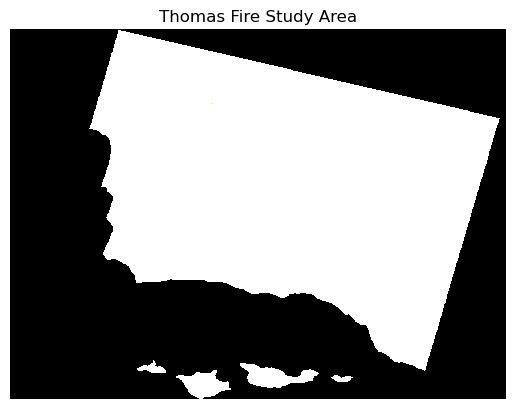

In [25]:
# Plot the landsat bands in true color
landsat[['red', 'green', 'blue']].to_array().plot.imshow()

plt.title("Thomas Fire Study Area") # Add title
plt.axis('off') # Removing axis labels and ticks
plt.show() # Display the plot

Hmmmmm.... something here doesn't look right! The map shows up in black and white when I was expecting it to look like a true color image.

This is because the clouds in the image introduce extreme, outlier values. By setting the `robust = True` parameter in the in `.imshow()`, I adjust the color scale based on the 2nd and 98th percentiles of the values, which helps minimize the influence of these outliers. This allows the color ramp to more accurately reflect the distribution of values where most of the data lies, providing a clearer representation of the underlying true color patterns in the image.

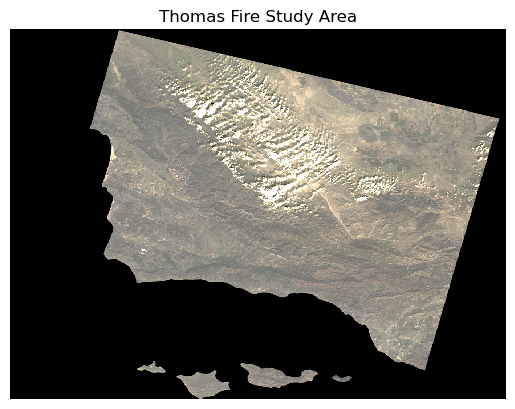

In [26]:
# Plot the landsat bands in true color
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust=True) # scale on the 2 & 98th percentiles

plt.title("Thomas Fire Study Area") # Add title
plt.axis('off') # Remove axis labels and ticks
plt.show() # Display the plot

Ahhh, much better! Now this is more like what I was expecting to see in my true color image.

This map helps me get a feel for what the landscape looks like, but it is still difficult for me to distinguish between landcover like healthy vegetation and bare ground, since the green, brown, and tan colors don't contrast strongly.

### Step 1F. Visualize the Landsat data in false
Next, I'd like to see if I can visualize the burned area better by integrating other bands of the landsat image in a 'false-color' composite. False-color images use at least one wavelength outside the visible range, like near-infrared, which can highlight things that we can't see with our bare eyes.

Vegetation strongly reflects in the near-infrared (NIR) and short-wave infrared (SWIR) bands and absorbs in the red, so visualizing these bands can help me distinguish between healthy vegetated from bare ground. For this reason, I will create a false-color composite using the SWIR, NIR, and red bands (SWIR-NIR-R) to better distinguish between vegetation and the Thomas Fire burned area.

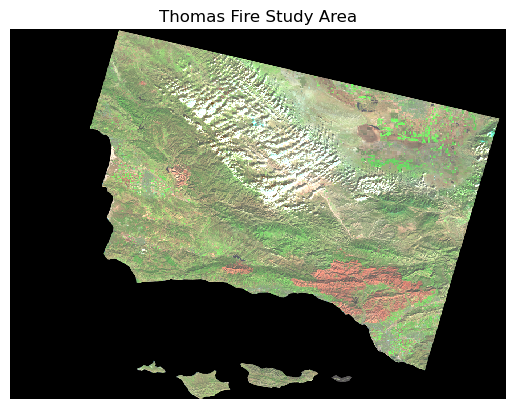

In [27]:
# Select and plot swir, nir, and red variables
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust=True) # scale on the 2 & 98th percentiles

plt.title("Thomas Fire Study Area") # Add title
plt.axis('off') # Remove axis labels and ticks
plt.show() # Display the plot

That worked! Now I can much more easily distinguish between vegetation (green) and bare ground or stressed vegetation (tan and red). In the bottom right, I can make out a large irregular red shape which lines up with the area that the Thomas Fire burned.

### Step 1G. Overlay the Thomas Fire boundary on the false color image

Now my final step is to overlay the false-color image with the Thomas Fire boundary to see how well the composite image picks up the burned area.

/tmp/ipykernel_3552418/3966502035.py:24: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(thomas_fire,loc='upper right', labels = ["Thomas Fire"]) # add legend


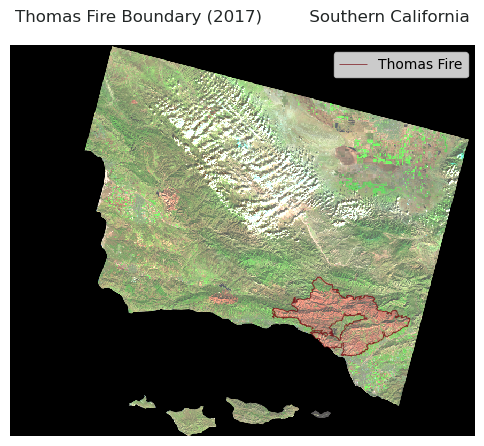

In [28]:
# Select false color SWIR-NIR-red bands and set to array
false_color = landsat[['swir22', 'nir08', 'red']].to_array()

# Set aspect ratio for map
fire_aspect_ratio = landsat.rio.shape[1] / landsat.rio.shape[0]

# Set figure parameters
fig, ax = plt.subplots(figsize=(6, 6*fire_aspect_ratio))

# Add false color imagery for background
false_color.plot.imshow(ax = ax,
                        robust=True) 
# Add thomas fire boundary
thomas_fire.boundary.plot(ax=ax,
                color = "#780B12",
                linewidth = 0.6,
                alpha = 0.8)
# Add title
ax.set_title('Thomas Fire Boundary (2017)         Southern California',
            color="#222626", 
            fontsize=12)

ax.axis('off') # Remove axis labels and ticks
plt.legend(thomas_fire,loc='upper right', labels = ["Thomas Fire"]) # add legend
plt.show() # Display the plot

This map shows the burn perimeter, outlined in dark red, for the Thomas Fire which occured in 2017. The boundary is overlayed onto a false color satellite image of the region, combining short-wave infrared (SWIR), near-infrared (NIR), and red bands to highlight vegetation (green) versus the burn scar (red). This overlay shows that the boundary of the burn scar aligns well with area in red in false color composite. When looking back at the true color image, this false-color map demonstrates the ability of the false color images to pick out land surface characteristics beyond what our bare eyes can see.

In [29]:
# Display all columns in preview
pd.set_option("display.max.columns", None)

# Part 2

In [30]:
# Import libraries
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

# Read in AQI data
aqi_17 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip', compression='zip')
aqi_18 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip', compression='zip')


<!-- END QUESTION -->

## 3
a. and b. Use the next two code cells to look at the head of both data frames. Store your results in `aqi_17_head` and `aqi_18_head`. 

In [31]:
# a.
# Look at the head, first 5 entries, of the AQI 2017 data
aqi_17_head = aqi_17.head()

In [32]:
# b.
# Look at the head, first 5 entries, of the AQI 2018 data
aqi_18_head = aqi_18.head()

*ANSWER:* 
- I used `dtypes` to see the data types for the different columns.
- I used `max` and `min` to find the max and min AQI values for the datasets. 
- I used `value_counts` to find the value counts of observations that fell in the different Category Ratings

I found that the means were similar between the years but the max for 2017 was much higher. I also found that in 2017 there were more 'Hazardous'(71) category ratings than in 2018(30), which indicates that the presence of events in 2017 that contributed to low air quality.*

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## 4
We currently have two separate data frames. For this exercise we will need to "glue" them one on top of the other. The `pandas` function `pd.concat()` can achieve this. 

Pass `[aqi_17, aqi_18]` as the input of `pd.concat()` and store the output as  `aqi`.  
In the next line run `aqi`.

NOTE: When we concatenate data frames like this, without any extra parameters for `pd.concat()` the indices for the two dataframes are just "glued together", the index of the resulting dataframe is not updated to start from 0. Notice the mismatch between the index of `aqi` and the number of rows i the complete data frame.


In [33]:
# Combine the two datasets using `pd.concat`
aqi = pd.concat([aqi_17, aqi_18])

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## 5

Run the following code cell and use the next markdown cell to give a line by line explanation of the code below the comment "#Simplify column names". You might need to look up the `pandas` documentation.

In [34]:
# Initial column names: notice caps and spaces (difficult to work with!)
print(aqi.columns, '\n')

# Simplify column names
aqi.columns = (aqi.columns
                  .str.lower()
                  .str.replace(' ','_')
                )
print(aqi.columns, '\n')

Index(['State Name', 'county Name', 'State Code', 'County Code', 'Date', 'AQI',
       'Category', 'Defining Parameter', 'Defining Site',
       'Number of Sites Reporting'],
      dtype='object') 

Index(['state_name', 'county_name', 'state_code', 'county_code', 'date', 'aqi',
       'category', 'defining_parameter', 'defining_site',
       'number_of_sites_reporting'],
      dtype='object') 



#### Line by line explanation of above code

*ANSWER:* 

```
# Initial column names: notice caps and spaces (difficult to work with!)
print(aqi.columns, '\n')               # Prints original column names and sets a new text line

# Clean column names
aqi.columns = (aqi.columns # Select columns of the aqi dataframe      
        .str.lower()  # Set text in column names to be lowercase
                  .str.replace(' ','_')  # Replace spaces with underscore in column names
              )
              
# Confirm column names updated successfully**
- print(aqi.columns, '\n')  # Print updated column names and sets a new text line

```

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## 6
In the next code cell:

a. Select only data from `Santa Barbara` county and store it in a new variable `aqi_sb`.

b. Remove the `state_name`, `county_name`, `state_code` and `county_code` columns from `aqi_sb`.

Your dataframe should have the following columns in this order: `date`, `aqi`, `category`, `defining_parameter`, `defining_stie`, `number_of_sites_reporting`. 

In [35]:
# part a
# Subset AQI data to Santa Barbara county
aqi_sb = aqi[aqi['county_name'] == 'Santa Barbara']

# part b
# Remove the 'state_name', 'county_name', 'state_code' and 'county_code' columns from aqi_sb
aqi_sb = aqi_sb.drop(['state_name', 'county_name', 'state_code', 'county_code'], axis = 1)


<!-- END QUESTION -->

 
c. What is the data type of the `date` column? Store your answer in the `date_type` variable. Your answer should contain the type for the **date column only**. 

In [36]:
# Check the type of date column
date_type = type(aqi_sb.date)

<!-- BEGIN QUESTION -->

## 7
In the following cell:
1. Update the date column of `aqi_sb` to be a `pandas.datetime` object.
2. Update the index of `aqi_sb` to be the `date` column.

In [37]:
# part a
# Update the data column to datetime object
aqi_sb.date = pd.to_datetime(aqi_sb.date)

# part b
# Set date as the index of aqi_sb
aqi_sb = aqi_sb.set_index('date')

<!-- END QUESTION -->

## 8
In the next cell we will calculate an average over a [rolling window](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.rolling.html) using the `rolling()`method for `pandas.Series`:

- `rolling()` is a lazy method, so we need to specify what we want to calculate over each window before it does something. 
- in this example we use the aggregator function `mean()` to calculate the average over each window
- the parameter '5D' indicates we want the window for our rolling average to be 5 days. 
- we get a `pandas.Series` as ouput

Store your answer in the `rolling_average` variable. You should have two columns in your series, `date` and the averages. 

In [38]:
# Calculate AQI rolling average over 5 days
rolling_average = aqi_sb['aqi'].rolling(window = '5D').mean()
rolling_average

date
2017-01-01    39.000000
2017-01-02    39.000000
2017-01-03    49.666667
2017-01-04    45.750000
2017-01-05    44.000000
                ...    
2018-12-27    41.200000
2018-12-28    38.600000
2018-12-29    38.200000
2018-12-30    38.200000
2018-12-31    38.800000
Name: aqi, Length: 730, dtype: float64

## 9 

Without creating any new variables, add the mean of the AQI over a 5-day rolling window as a new column named `five_day_average` to the `aqi_sb` dataframe. 

In [39]:
# Add calculated rolling averages as 'five_day_average' column
aqi_sb["five_day_average"] = rolling_average

aqi_sb

,aqi,category,defining_parameter,defining_site,number_of_sites_reporting,five_day_average
date,,,,,,
2017-01-01,39,Good,Ozone,06-083-4003,12,39.000000
2017-01-02,39,Good,PM2.5,06-083-2011,11,39.000000
2017-01-03,71,Moderate,PM10,06-083-4003,12,49.666667
2017-01-04,34,Good,Ozone,06-083-4003,13,45.750000
2017-01-05,37,Good,Ozone,06-083-4003,12,44.000000
...,...,...,...,...,...,...
2018-12-27,37,Good,Ozone,06-083-1025,11,41.200000
2018-12-28,39,Good,Ozone,06-083-1021,12,38.600000
2018-12-29,39,Good,Ozone,06-083-1021,12,38.200000


<!-- BEGIN QUESTION -->

## 10
Make a line plot showing both the daily AQI and the 5-day average (5-day average on top of the AQI). Make necessary updates for the plot to be accurate, informative, and polished, even if simple. You're welcome to use plotting methods and packages beyond what we have covered in class! 

Can you see the AQI going up during the Thomas Fire in December 2017?

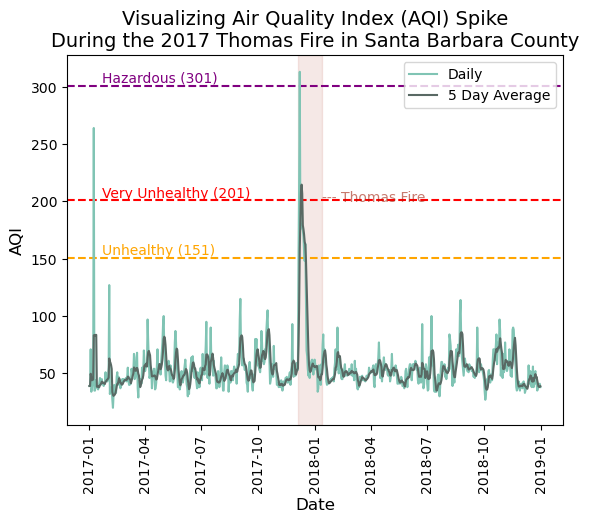

In [40]:
# Define the start and end date of the fire
fire_start = pd.to_datetime('2017-12-04')
fire_end = pd.to_datetime('2018-01-12')

# Add span indicating Thomas Fire
plt.axvspan(fire_start, fire_end, color='#A3210D', alpha = 0.1)
plt.annotate('--- Thomas Fire', xy = (fire_end, 200), color='#A3210D', alpha = 0.6)

# Add dashed horizontal lines for AQI levels
plt.axhline(y=151, color='orange', linestyle='--', label='_nolegend_', linewidth=1.5)
plt.axhline(y=201, color='red', linestyle='--', label='_nolegend_', linewidth=1.5)
plt.axhline(y=301, color='purple', linestyle='--', label='_nolegend_', linewidth=1.5)

# Add text labels on the lines
plt.text(aqi_sb.index[0] + pd.Timedelta(days=20), 151, 'Unhealthy (151)', color='orange', fontsize=10, verticalalignment='bottom')
plt.text(aqi_sb.index[0]+ pd.Timedelta(days=20), 201, 'Very Unhealthy (201)', color='red', fontsize=10, verticalalignment='bottom')
plt.text(aqi_sb.index[0]+ pd.Timedelta(days=20), 301, 'Hazardous (301)', color='purple', fontsize=10, verticalalignment='bottom')

# Plot AQI
plt.plot(aqi_sb.index, aqi_sb.aqi, color='#80C4B4', label='Daily')
plt.plot(aqi_sb.index, aqi_sb.five_day_average, color='#596964', label='5 Day Average')
plt.title('Visualizing Air Quality Index (AQI) Spike\nDuring the 2017 Thomas Fire in Santa Barbara County', fontsize=14)

# Plot Customization
plt.legend()
plt.xlabel('Date', fontsize=12)
plt.ylabel('AQI', fontsize=12)
plt.xticks(rotation=90)
plt.show()

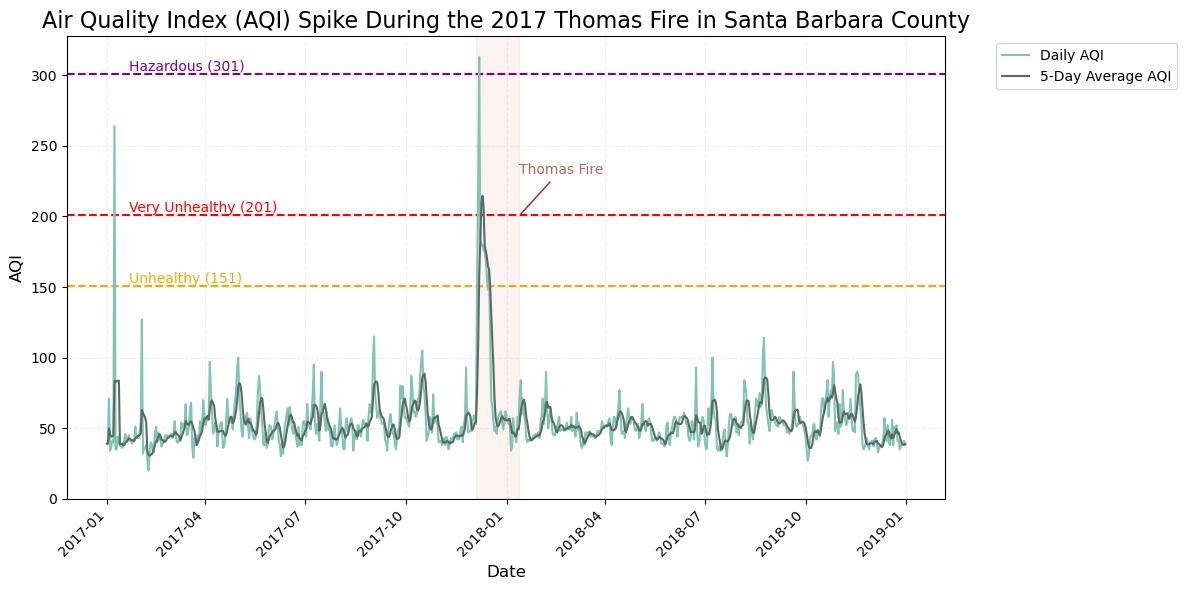

In [41]:
# Set figure size (wider plot)
fig, ax = plt.subplots(figsize=(12, 6)) 

# Add vertical span indicating Thomas Fire
plt.axvspan(pd.to_datetime('2017-12-04'), pd.to_datetime('2018-01-12'), color ='#A3210D', alpha = 0.05)
plt.annotate('Thomas Fire', xy = (pd.to_datetime('2018-01-12'), 200), xytext = (pd.to_datetime('2018-01-12'), 230),
             arrowprops=dict(arrowstyle = '-', color='#A3210D'), color='#A3210D', alpha=0.7)

# Add dashed horizontal lines for AQI levels
plt.axhline(y=151, color = 'orange', linestyle ='--', label ='_nolegend_', linewidth=1.5)
plt.axhline(y=201, color = 'red', linestyle ='--', label ='_nolegend_', linewidth=1.5)
plt.axhline(y=301, color = 'purple', linestyle ='--', label ='_nolegend_', linewidth=1.5)

# Add text labels on the lines, moved right by a bit for better placement
plt.text(aqi_sb.index[0] + pd.Timedelta(days = 20), 151, 'Unhealthy (151)', color ='orange', fontsize=10, verticalalignment='bottom')
plt.text(aqi_sb.index[0] + pd.Timedelta(days = 20), 201, 'Very Unhealthy (201)', color ='red', fontsize=10, verticalalignment='bottom')
plt.text(aqi_sb.index[0] + pd.Timedelta(days = 20), 301, 'Hazardous (301)', color ='purple', fontsize=10, verticalalignment='bottom')

# Plot AQI and 5-day average
plt.plot(aqi_sb.index, aqi_sb.aqi, color='#80C4B4', label='Daily AQI')
plt.plot(aqi_sb.index, aqi_sb.five_day_average, color='#596964', label='5-Day Average AQI')

# Title and Labels
plt.title('Air Quality Index (AQI) Spike During the 2017 Thomas Fire in Santa Barbara County', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('AQI', fontsize=12)

# Customize ticks
plt.xticks(rotation =45, ha ='right')
plt.yticks(range(0, 350, 50))

# Add gridlines for better readability
plt.grid(True, linestyle ='--', alpha = 0.2)

# Add Legend
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left', fontsize=10)

# Show plot
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()

Can you see the AQI going up during the Thomas Fire in December 2017?

This line chart shows Santa Barbara County's average air quality index (AQI), shown on the y-axis, by day from 2017-2018. The AQI is measured from 0 to 500, which indicates the quality of the air and its health effects with low values indicating the best air quality and higher values indicating lower air quality. The light blue line indicates the Daily Average AQI values, where the dark green line indicates the 5-Day Rolling Average, which takes softens the average based on the surrounding 5 day window. The figure shows a distinct spike in AQI in late 2017, during the Thomas Fire which burned from December 4, 2017 through January 12, 2018. At the start of the fire, the Daily AQI spiked to a harmful index level of over 300. The EPA designates AQI values of 301 and higher to be deemed as "Hazardous" and warns of emergency conditions where everyone, not just senstive populations, is likely to be affected. The figure identifies an additional brief but significant spike in Santa Barbara, where the AQI rose above 200, which the EPA ranks as 'Very Unhealthy'; this could suggest the occurance of another fire or event that contributed to the dramatic spike. 

---

title: "Analyzing Impacts of the Thomas Fire"
description: "In Santa Barbara & Ventura Counties (Dec. 2017 - Jan. 2018)"
author: 
  - name: Nicole
    url: https://github.com/nicolelpepper
    affiliation: Bren MEDS
    affiliation-url: https://bren.ucsb.edu/masters-programs/master-environmental-data-science/academics-meds-program
date: 2024-10-18
categories: [GIS, Remote-Sensing, MEDS]
image: thomas-fire.png
bibliography: references.bib
draft-mode: visible
citation:
      url: https://github.com/nicolelpepper/personalwebsite/2024-12-02-thomas-fire
editor_options: 
  chunk_output_type: console
  
---